<h1>Neural network Modeling</h1>

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import yfinance as yf
import torch.optim as optim
#from torchviz import make_dot
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
#from torchsummary import summary
from IPython.display import Image
import plotly.graph_objects as go
from IPython.display import Image, display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import warnings
import os
warnings.filterwarnings("ignore")
from pathlib import Path
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
import tempfile
from functools import partial
import sys

In [2]:
import random, numpy as np, torch
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
module_path = os.path.abspath(os.path.join('./finished_files_python/layers.py'))
if module_path not in sys.path:
    sys.path.append(module_path)

from finished_files_python.layers import *

<H2>Gathering data of CDPR stock tickers</H2>

In [4]:
#skip ticker generation if it's present in the folder. Yahoo sometimes is too heavily occupied and cannot answer
path = './data/prices/ticker.csv'

if not os.path.isfile(path):
    tck = yf.Ticker("ETH-USD")
    start_date = "2021-01-01"
    end_date = '2022-01-01'
    df = tck.history(start=start_date, end=end_date)
    df.to_csv('./data/CDPR_stock_data.csv', index=False)
else:
    df = pd.read_csv(path)

In [5]:
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-01 00:00:00+00:00,737.708374,749.201843,719.792236,730.367554,13652004358,0.0,0.0
2021-01-02 00:00:00+00:00,730.402649,786.798462,718.109497,774.534973,19740771179,0.0,0.0
2021-01-03 00:00:00+00:00,774.511841,1006.565002,771.561646,975.507690,45200463368,0.0,0.0
2021-01-04 00:00:00+00:00,977.058838,1153.189209,912.305359,1040.233032,56945985763,0.0,0.0
2021-01-05 00:00:00+00:00,1041.498779,1129.371460,986.811279,1100.006104,41535932781,0.0,0.0


In [6]:
#use only if first block fails for some reason
#df.to_csv('./data/prices/ticker.csv', index=False)

<h2>Drop the dividends and Stock Splits columns. We don't include them in our analysis.</h2>

In [7]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)
df['Volume'] = df['Volume'].astype('float64')
columns=['Open', 'High', 'Low', 'Close', 'Volume']
df.columns == columns

array([ True,  True,  True,  True,  True])

<h2>Plot to check for missing data</h2>

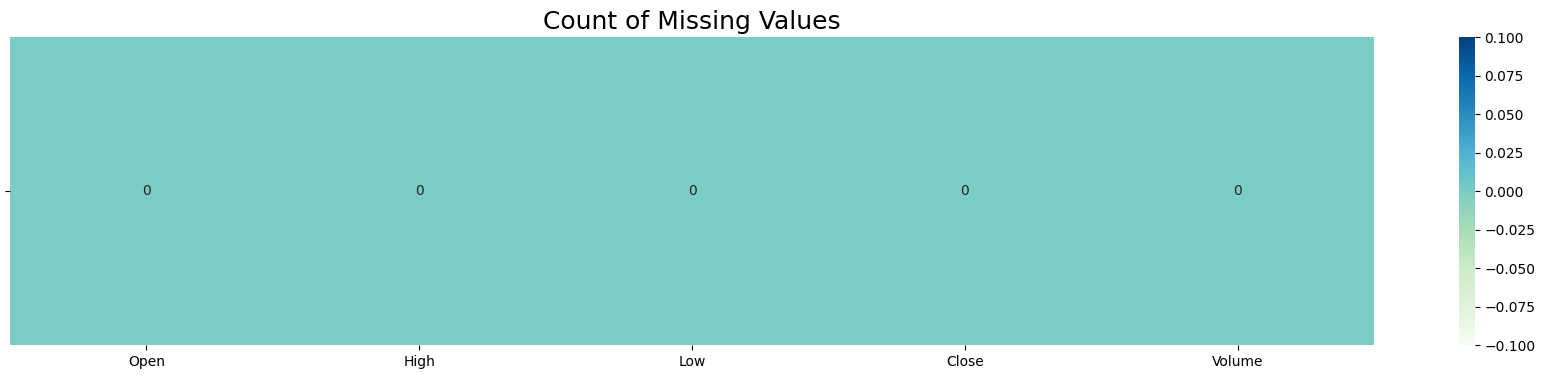

In [8]:
plt.figure(figsize=(22,4))
sns.heatmap((df.isna().sum()).to_frame(name='').T,cmap='GnBu', annot=True,
             fmt='0.0f').set_title('Count of Missing Values', fontsize=18)
plt.show()

In [9]:
df.describe().T.style.background_gradient(cmap='GnBu', axis=1)

,count,mean,std,min,25%,50%,75%,max
Open,365.000000,2771.215477,1029.448767,730.402649,1886.667603,2629.748779,3632.219727,4810.071289
High,365.000000,2872.125942,1048.947824,749.201843,1959.696289,2750.534912,3827.981934,4891.704590
Low,365.000000,2658.899019,1004.316330,718.109497,1811.245850,2485.375000,3544.640381,4718.039062
Close,365.000000,2778.354149,1023.543690,730.367554,1895.552124,2633.518311,3638.122070,4812.087402
Volume,365.000000,27280819104.775341,11663121397.180578,10894785525.000000,18991302378.000000,23868866254.000000,32275969215.000000,84482912776.000000


<h2>Visualizing data.</h2>

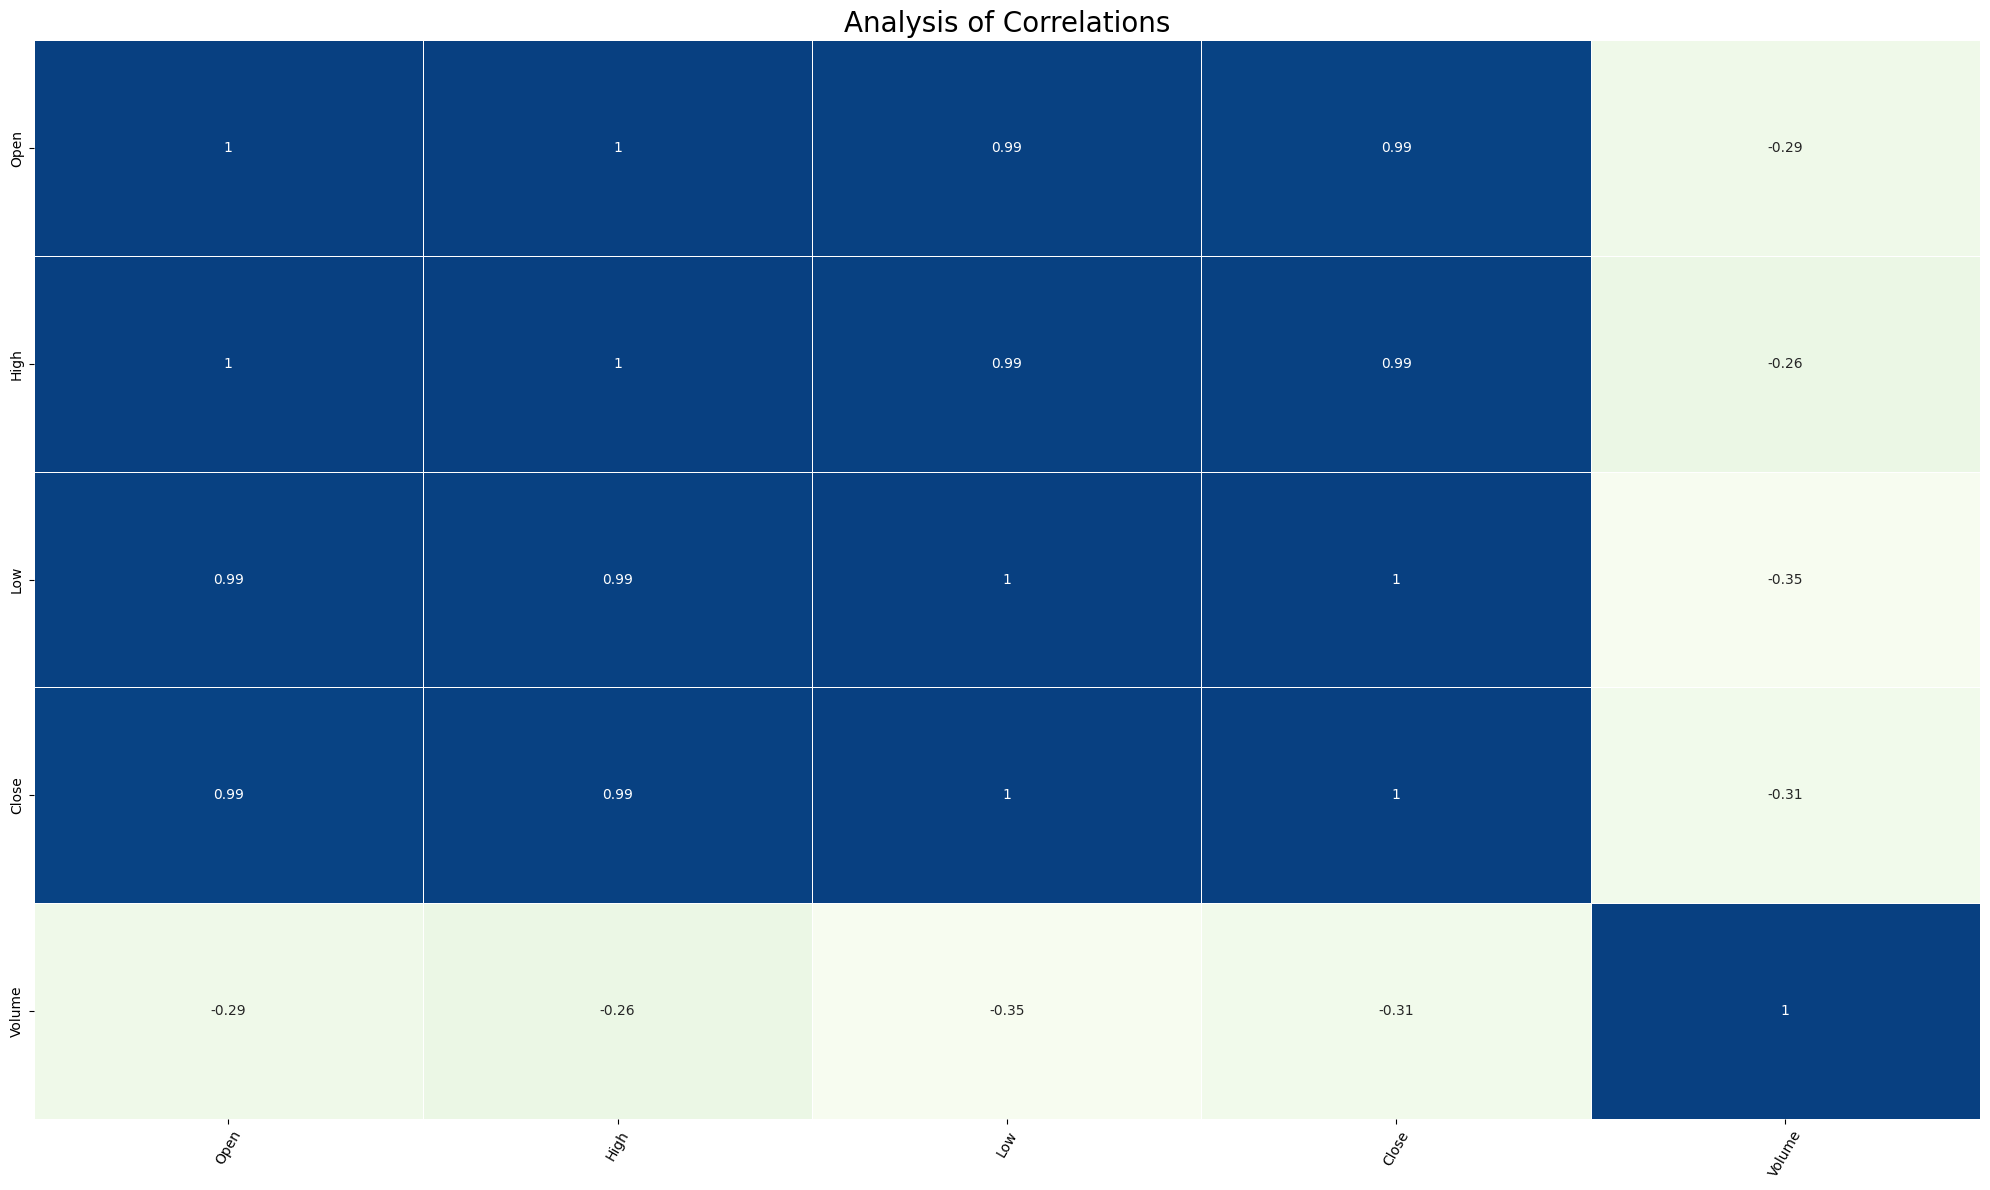

In [10]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(numeric_only=True), cmap="GnBu", annot=True, linewidths=.6 , cbar = False)
plt.xticks(rotation=60, size=10)
plt.yticks(size=10)
plt.title('Analysis of Correlations', size=20)
plt.tight_layout()
plt.show()

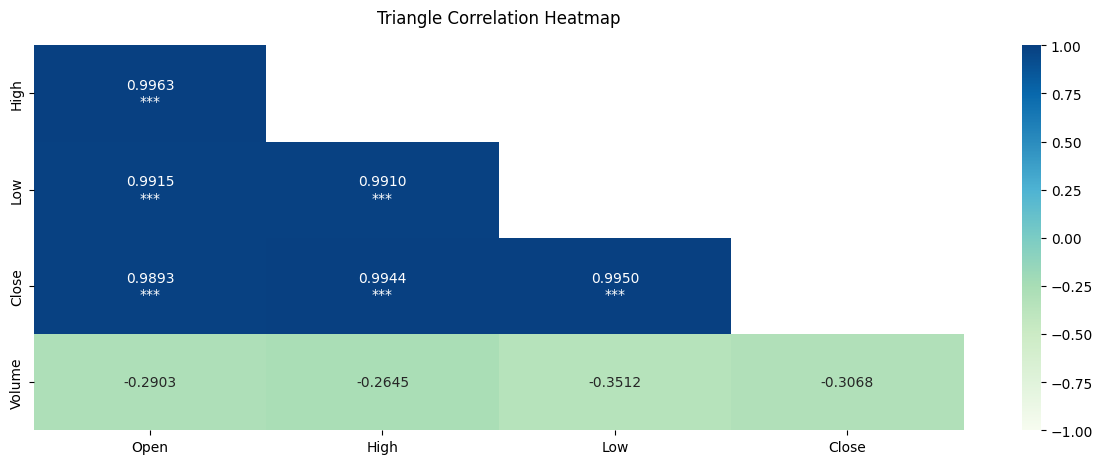

In [11]:
corr = df.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(15, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
cut_off = 0.25
extreme_1 = 0.5
extreme_2 = 0.75
extreme_3 = 0.9
mask |= np.abs(corr) < cut_off
corr = corr[~mask]
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.4f}"
          + ('' if abs(val) < extreme_1 else '\n*')
          + ('' if abs(val) < extreme_2 else '*')
          + ('' if abs(val) < extreme_3 else '*')
          for val in row] for row in corr.to_numpy()]
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='', cmap='GnBu')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 12}, pad=16)
plt.show()

<h2>Further analysis confirms strong correlation between prices. However the correlation between them and volume remains weak. It also further confirms multimodal distribution.<h2>

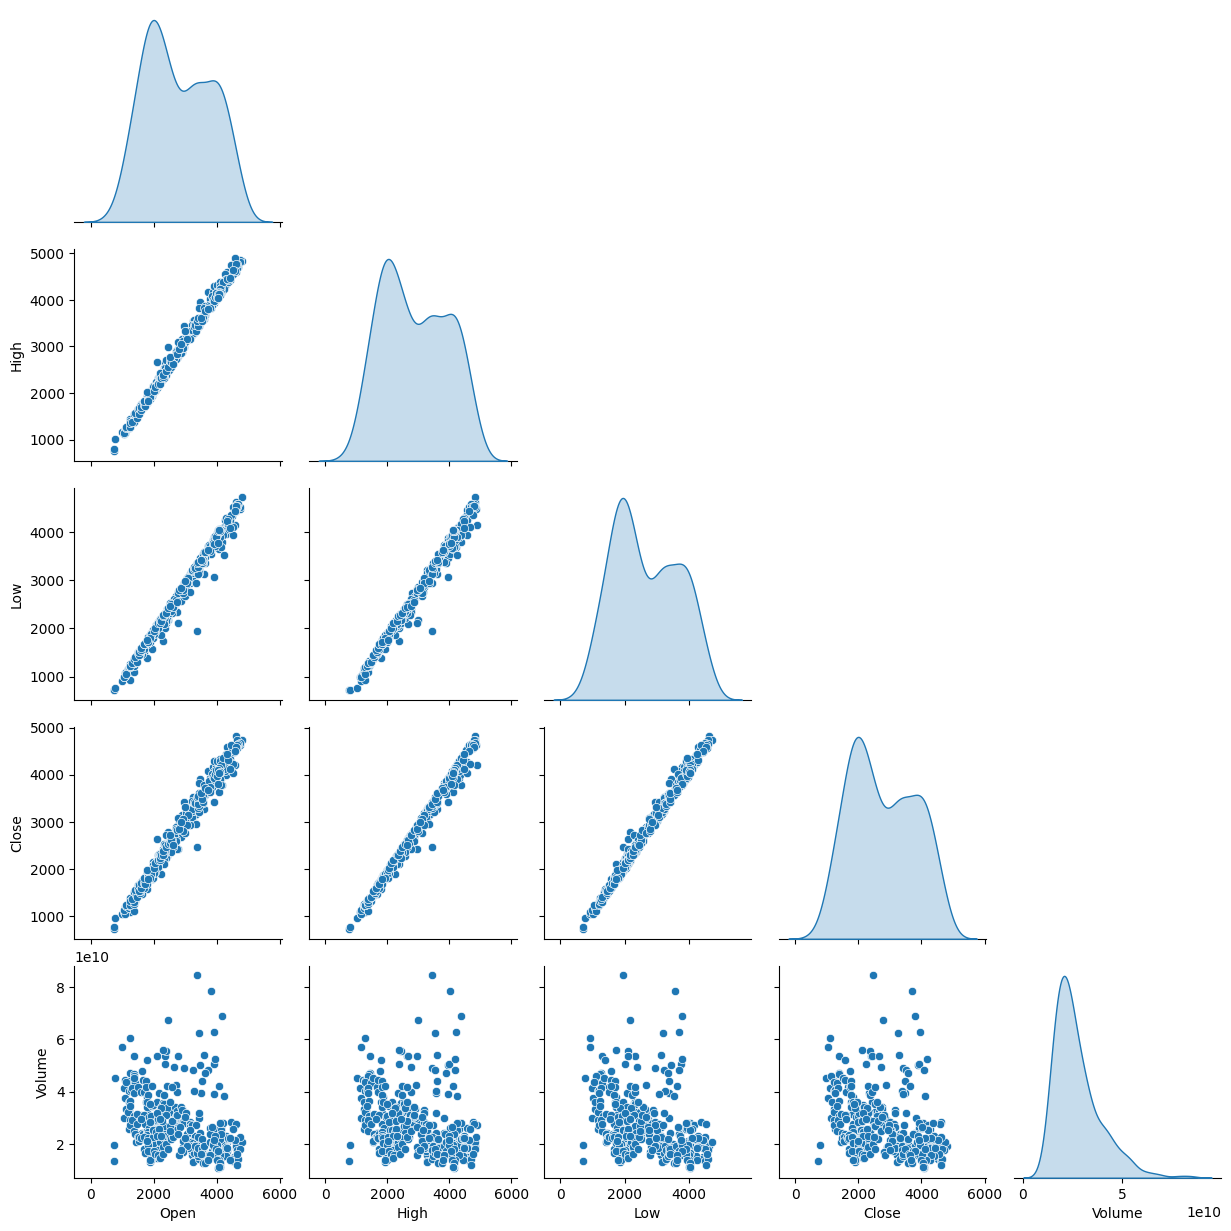

In [12]:
custom_palette = sns.color_palette(['#2a9d8f', '#f4a261'])
sns.pairplot(data=df, diag_kind='kde', palette=custom_palette,corner=True)
plt.gcf().set_facecolor('#ffffff')
plt.show()

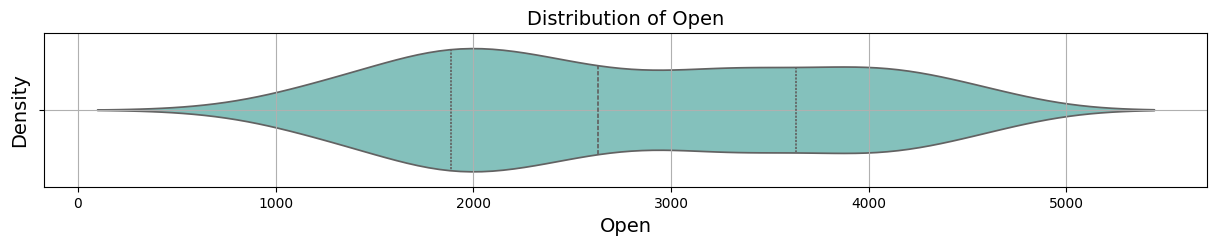

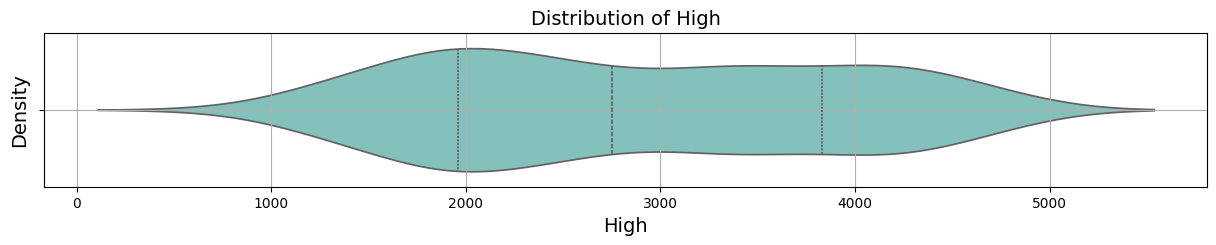

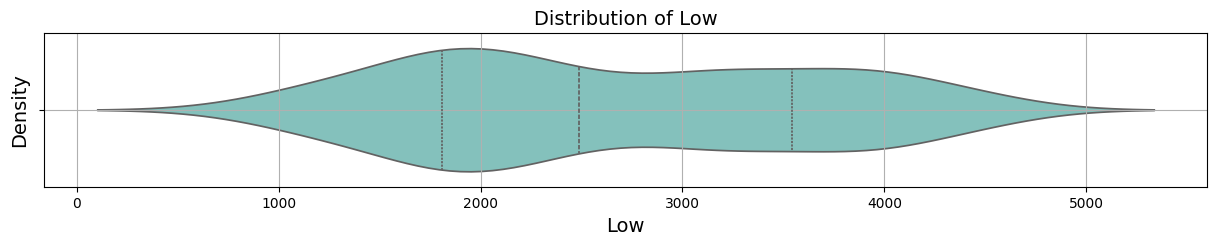

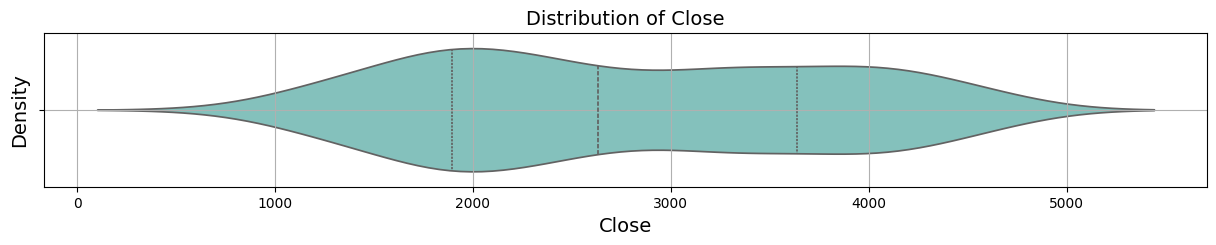

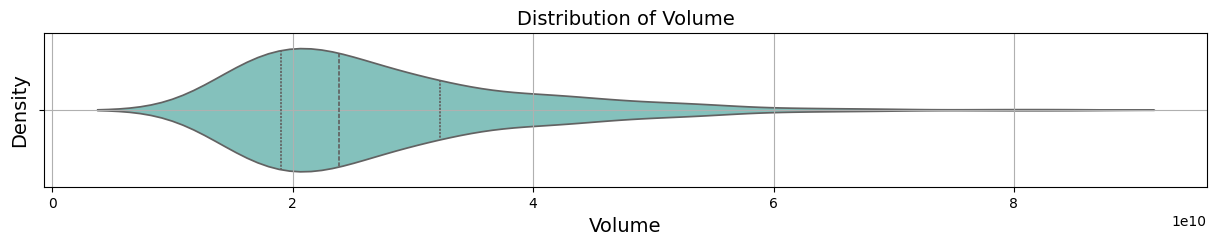

In [13]:
palette = "GnBu"
for column in columns:
    plt.figure(figsize=(15, 2)) 
    sns.violinplot(x=df[column], palette=palette, inner="quartile")  
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True)
    plt.show()

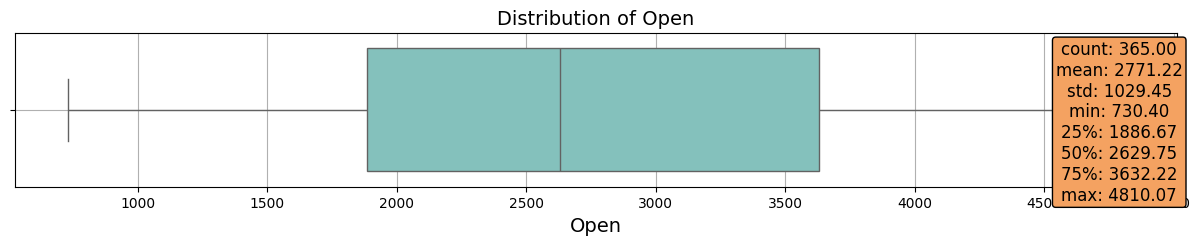

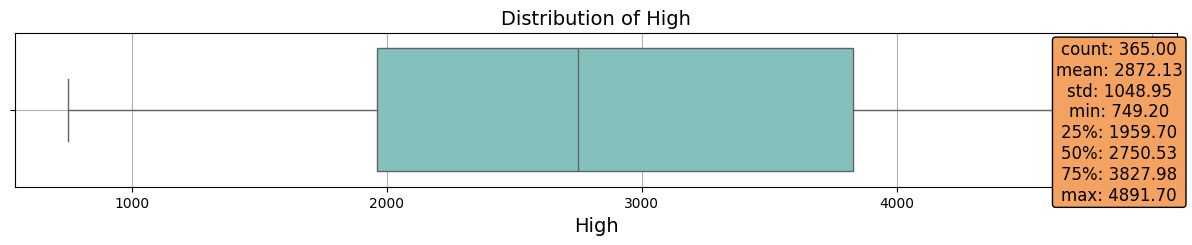

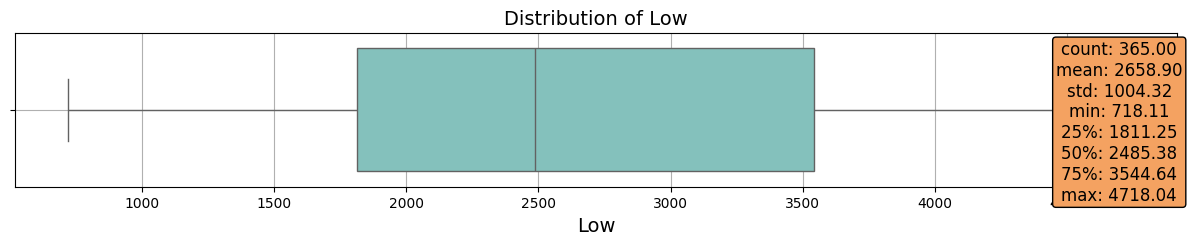

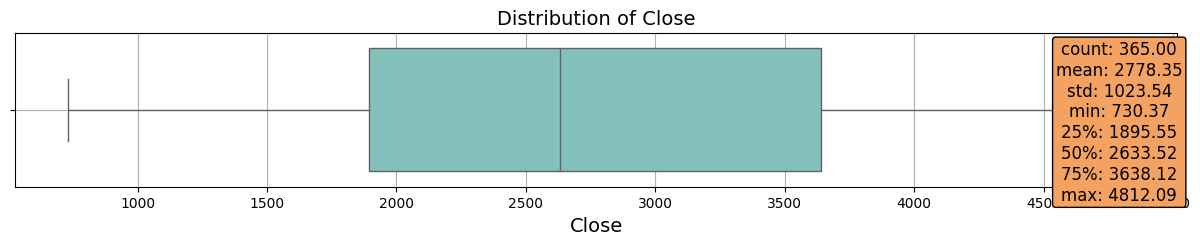

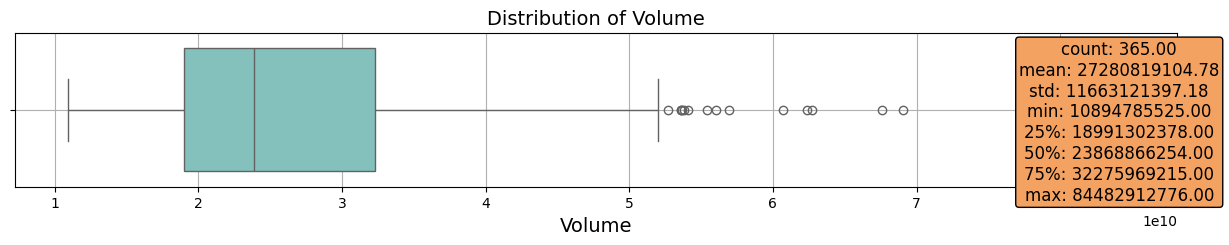

In [14]:
palette = "GnBu" 
for column in columns:
    plt.figure(figsize=(15, 2)) 
    sns.boxplot(x=df[column], palette=palette)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    stats = df[column].describe()
    stats_text = "\n".join([f"{key}: {value:.2f}" for key, value in stats.items()])
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', 
             horizontalalignment='center', bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='#f4a261'))
    plt.grid(True) 
    plt.show()

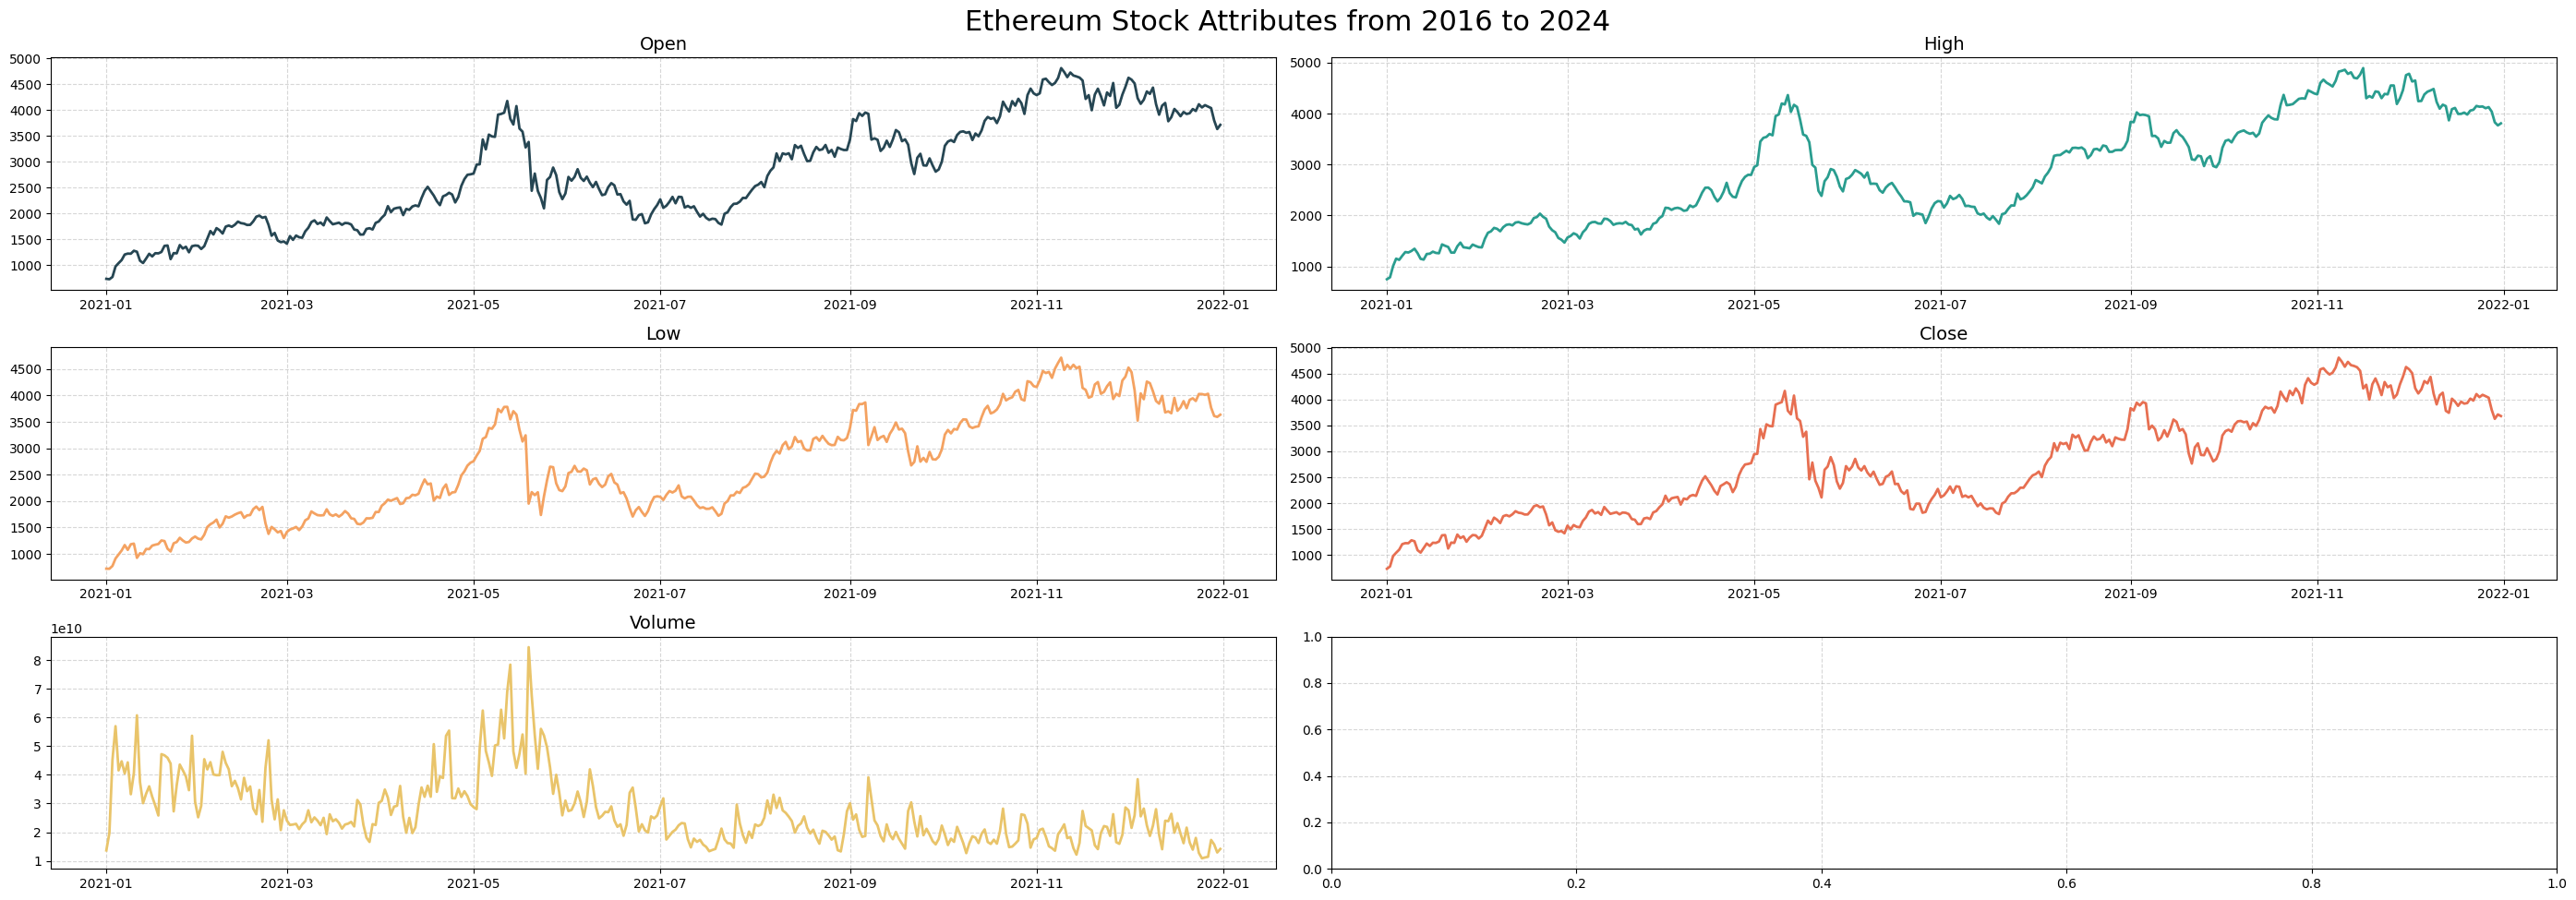

In [15]:
import matplotlib.pyplot as plt
x=df.index
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51','#e9c46a', '#e9d8a6']
plt.figure(figsize=(28, 10))
plt.subplot(3, 2, 1)
plt.plot(x, df['Open'], color=colors[0], linewidth=2)
plt.title('Open', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 2)
plt.plot(x, df['High'], color=colors[1], linewidth=2)
plt.title('High', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 3)
plt.plot(x, df['Low'], color=colors[2], linewidth=2)
plt.title('Low', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 4)
plt.plot(x, df['Close'], color=colors[3], linewidth=2)
plt.title('Close', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 5)
plt.plot(x, df['Volume'], color=colors[4], linewidth=2)
plt.title('Volume', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 6)
plt.grid(True, linestyle='--', alpha=0.5)
plt.suptitle('Ethereum Stock Attributes from 2016 to 2024', fontsize=22, y=0.97)
plt.tight_layout()
plt.show()


In [16]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-01 00:00:00+00:00,737.708374,749.201843,719.792236,730.367554,1.365200e+10
2021-01-02 00:00:00+00:00,730.402649,786.798462,718.109497,774.534973,1.974077e+10
2021-01-03 00:00:00+00:00,774.511841,1006.565002,771.561646,975.507690,4.520046e+10
2021-01-04 00:00:00+00:00,977.058838,1153.189209,912.305359,1040.233032,5.694599e+10
2021-01-05 00:00:00+00:00,1041.498779,1129.371460,986.811279,1100.006104,4.153593e+10


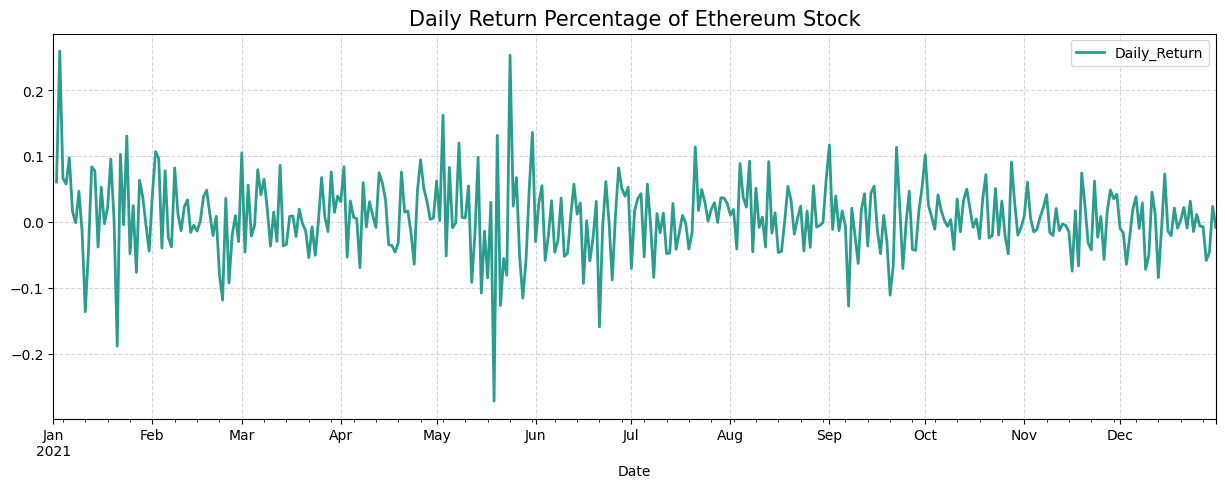

In [17]:
df['Daily_Return'] = df['Close'].pct_change()
df['Daily_Return'].plot(legend=True, figsize=(15, 5), color='#2a9d8f', linewidth=2)
plt.title('Daily Return Percentage of Ethereum Stock', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<h2>Modeling data</h2>

In [18]:
if os.path.isfile('./data/prices/masked_ticker.csv'):
    df5 = pd.read_csv('./data/prices/masked_ticker.csv')
else:
    tck = yf.Ticker("ETH-USD")
    # defining the start date 
    start_date = "2021-01-01"
    end_date = '2022-01-01'
    # historical data
    df5 = tck.history(start=start_date, end=end_date)
    df5 = df5.drop(['Dividends', 'Stock Splits'], axis=1)

In [19]:
df5.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-01 00:00:00+00:00,737.708374,749.201843,719.792236,730.367554,13652004358
2021-01-02 00:00:00+00:00,730.402649,786.798462,718.109497,774.534973,19740771179
2021-01-03 00:00:00+00:00,774.511841,1006.565002,771.561646,975.507690,45200463368
2021-01-04 00:00:00+00:00,977.058838,1153.189209,912.305359,1040.233032,56945985763
2021-01-05 00:00:00+00:00,1041.498779,1129.371460,986.811279,1100.006104,41535932781


In [20]:
if os.path.isfile('./data/masked_ticker.csv'):
    pass
else:
    df5.to_csv('./data/masked_ticker.csv')

In [21]:
df5 = df5.reset_index()

In [22]:
df5['Volume'] = df5['Volume'].astype('float64')

<h2>Using indicators to further analyse the data</h2>

In [23]:
def get_tech_ind(data):
    data['MA5'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA10'] = data.iloc[:,4].rolling(window=10).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bands
    data['8SD'] = data.iloc[:, 4].rolling(8).std()
    data['upper_band'] = data['MA10'] + (data['8SD'] * 2)
    data['lower_band'] = data['MA10'] - (data['8SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    return data

In [24]:
start_date = '2015-01-01'
end_date = '2025-01-01'

mask = (df5['Date'] >= start_date) & (df5['Date'] < end_date)

df5 = df5.loc[mask]

In [25]:
df5.tail(3)

,Date,Open,High,Low,Close,Volume
362,2021-12-29 00:00:00+00:00,3797.436279,3827.981934,3612.795898,3628.531738,1.572256e+10
363,2021-12-30 00:00:00+00:00,3632.219727,3767.559814,3595.204834,3713.852051,1.292538e+10
364,2021-12-31 00:00:00+00:00,3713.430176,3807.288818,3636.869873,3682.632812,1.415729e+10


<h2>Appending the data from sentiment analysis file we export into the other folder.</h2>

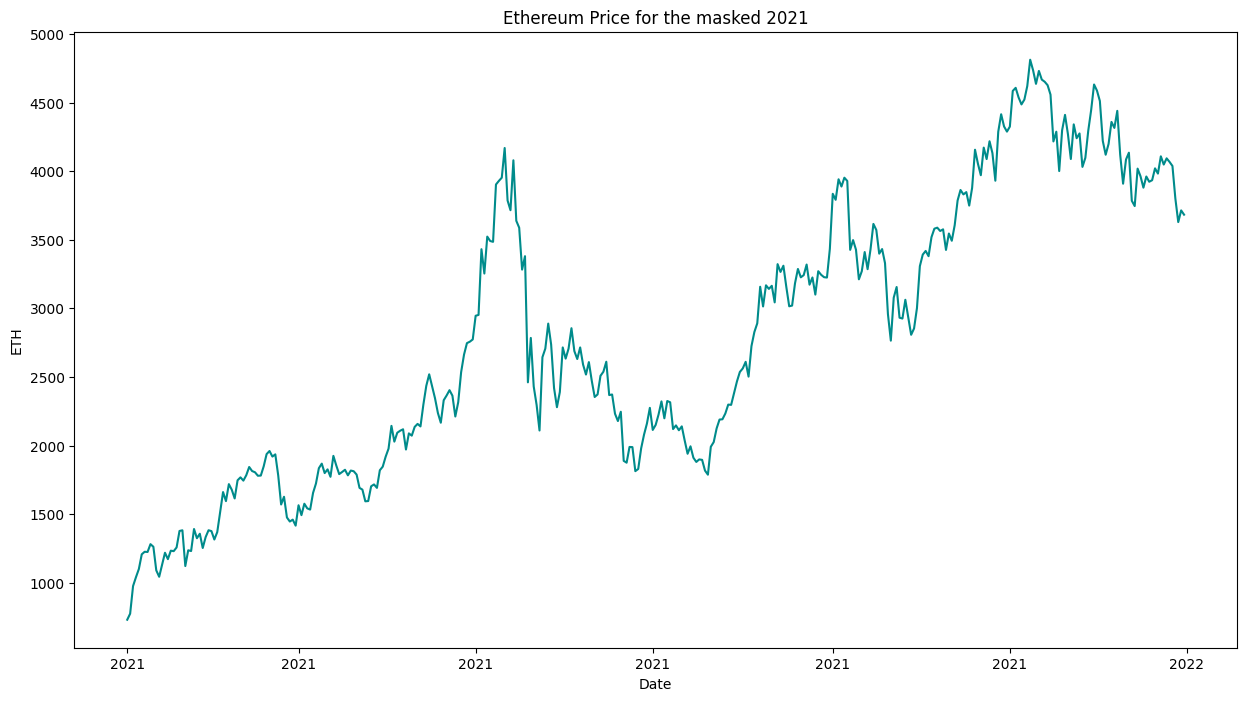

In [26]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df5['Date'], df5['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="ETH", title="Ethereum Price for the masked 2021")

ax.xaxis.set_major_formatter(DateFormatter("%Y"))

plt.show()

In [27]:
tech_df = get_tech_ind(df5)
dataset = tech_df.iloc[10:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA
0,2021-01-11 00:00:00+00:00,1261.622925,1261.622925,924.922607,1090.145386,6.073363e+10,1198.637556,1118.073859,36.767167,89.245201,1296.564261,939.583456,1147.247263
1,2021-01-12 00:00:00+00:00,1088.526733,1149.240234,1012.764160,1043.434570,3.749460e+10,1190.555908,1144.963818,26.421413,88.539272,1322.042362,967.885275,1078.038671
2,2021-01-13 00:00:00+00:00,1043.740967,1134.338501,994.549072,1130.739380,3.010979e+10,1179.645508,1160.486987,34.872771,85.214707,1330.916402,990.057572,1113.172499
3,2021-01-14 00:00:00+00:00,1130.231201,1244.163086,1093.060791,1218.453003,3.341092e+10,1178.613351,1178.308984,38.569672,85.764193,1349.837370,1006.780598,1183.359516
4,2021-01-15 00:00:00+00:00,1221.877197,1250.505859,1090.721069,1171.834595,3.597204e+10,1171.132987,1185.491833,22.663302,84.168607,1353.829048,1017.154619,1175.676235


In [28]:
df5['Date'] = pd.to_datetime(df5['Date'], utc=True)

<h2>Visualize the indicators</h2>

In [29]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA5'], label='Moving Average (5 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA10'], label='Moving Average (10 days)', color='r', linestyle='-.')
    ax.plot(dataset['Date'], dataset['8SD'], label='Moving Average (8 days)', color='r', linestyle='-.')
    ax.plot(dataset['Date'], dataset['EMA'], label='Exponential Moving Average (8 days)', color='r', linestyle='-.')
    
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

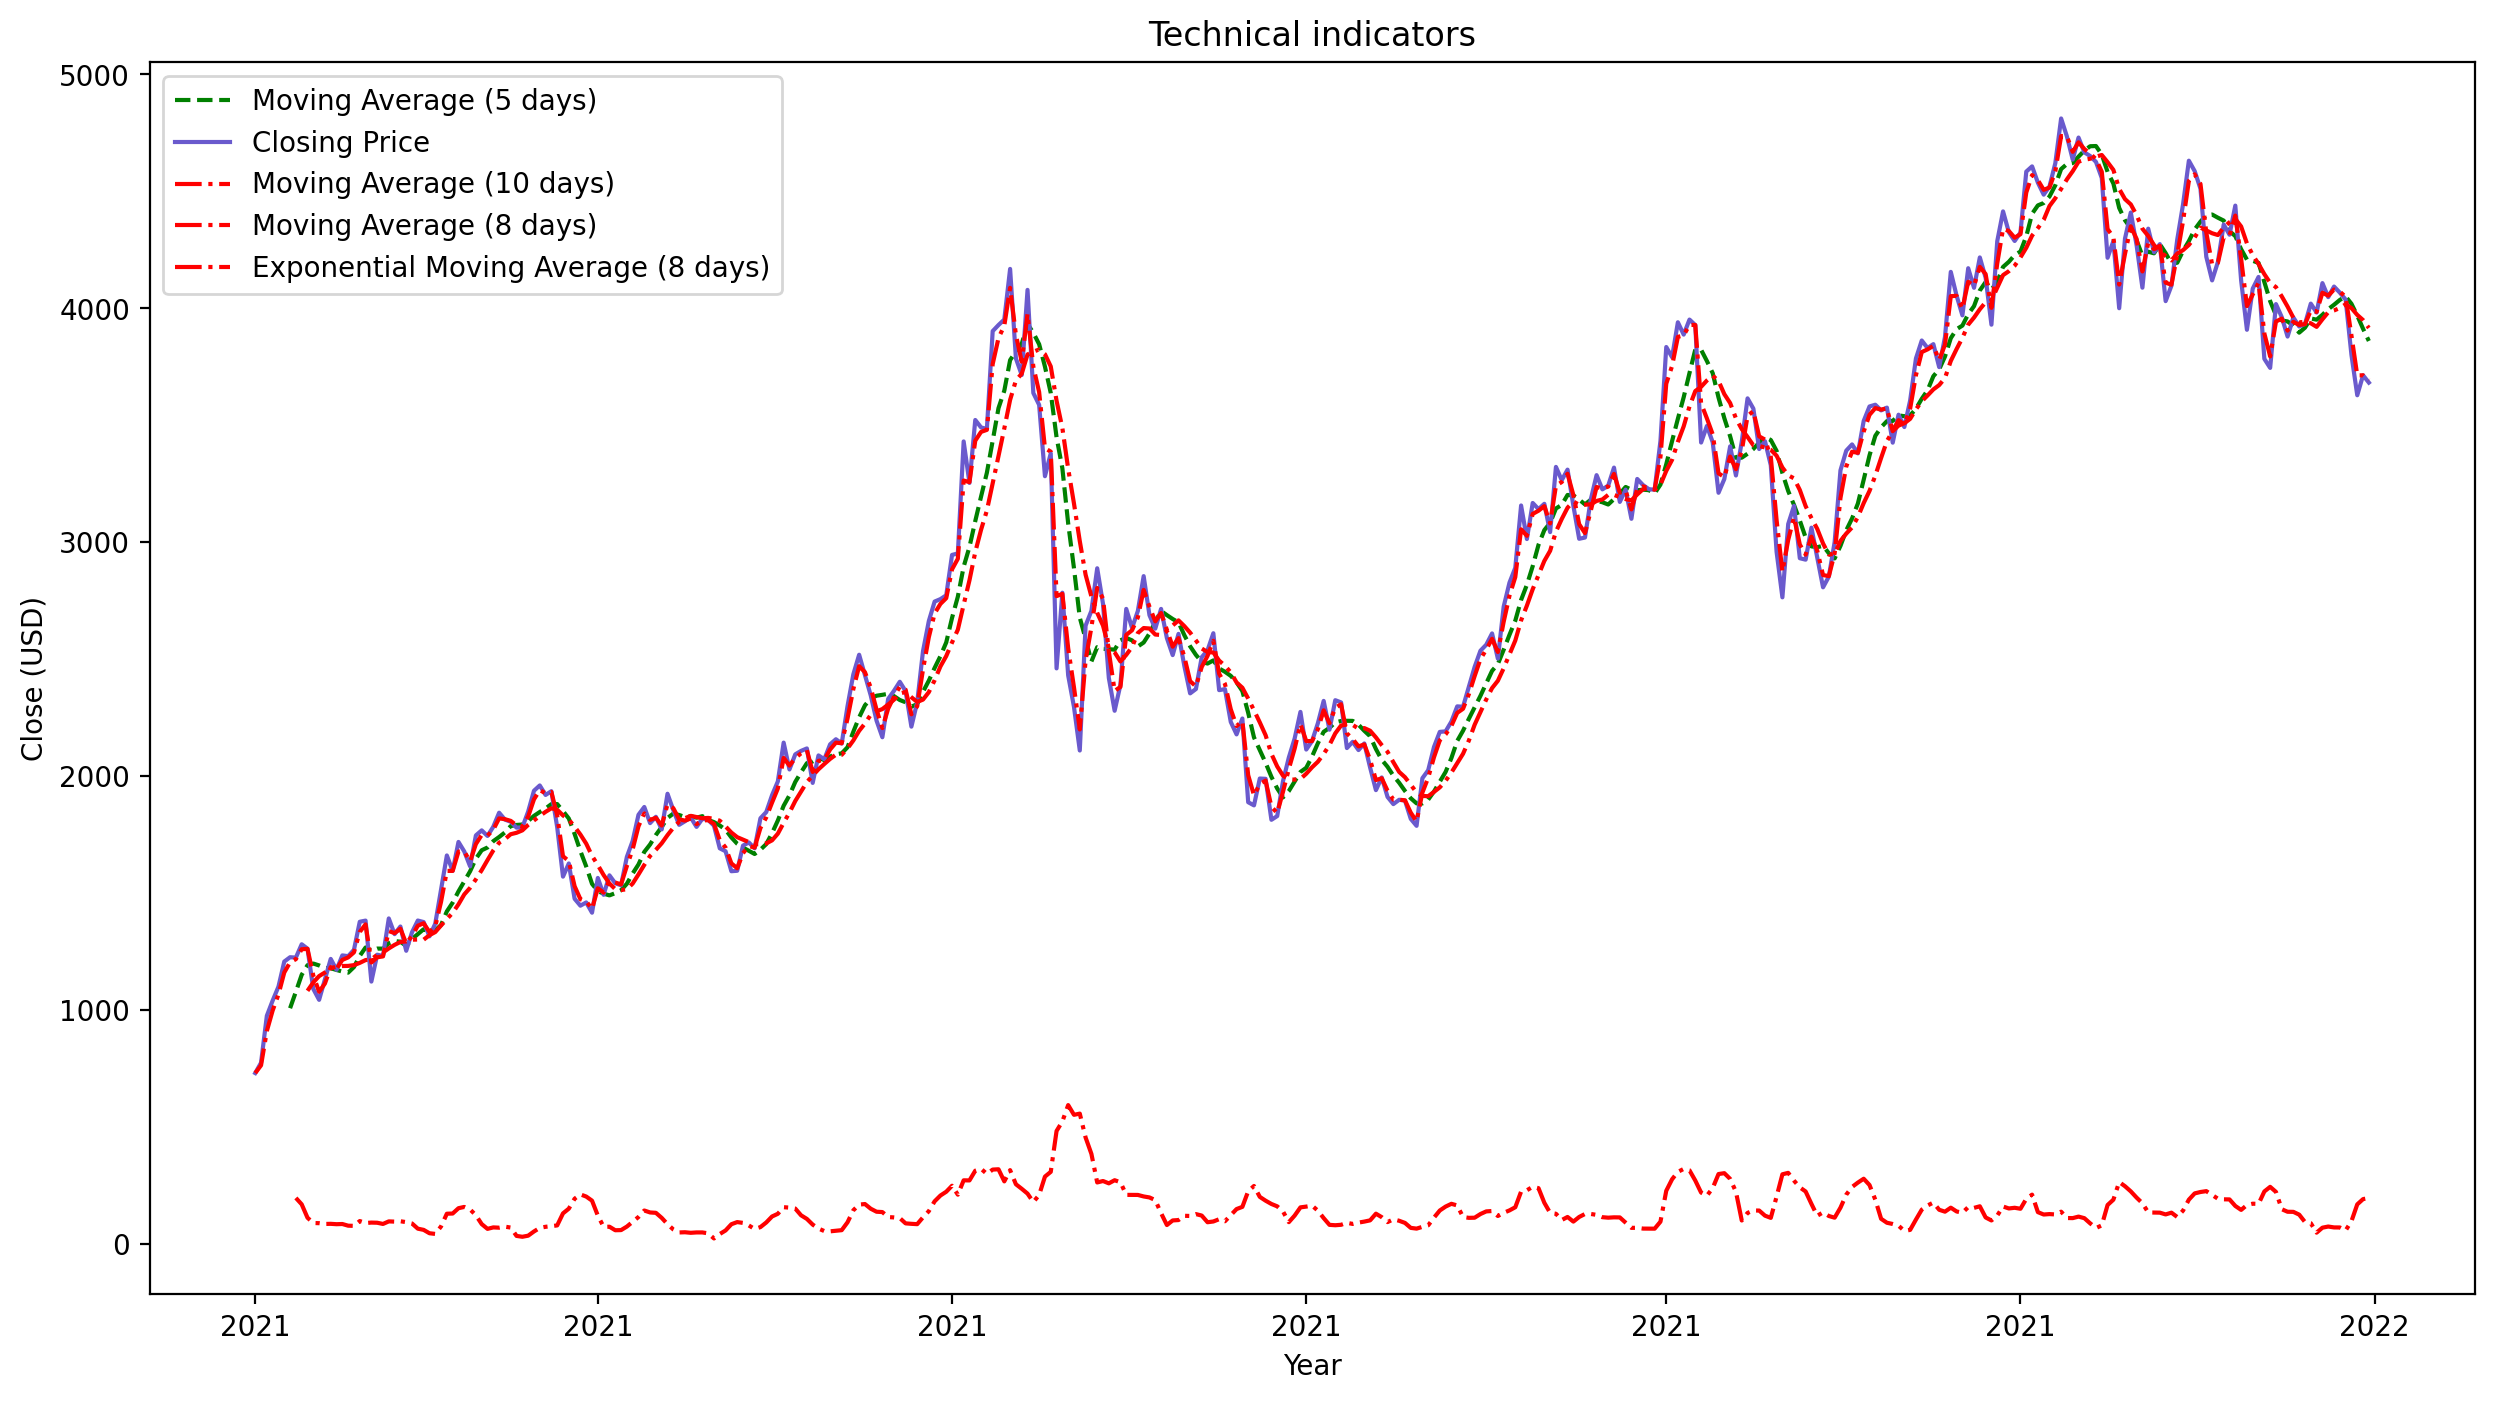

In [30]:
tech_ind(df5)

<h3>5 days and 10 days dataset copy</h3>

In [31]:
dataset_5_days = df5.iloc[6:,:].reset_index(drop=True)
dataset_5_days.head()

,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA
0,2021-01-07 00:00:00+00:00,1208.078369,1282.579590,1167.443115,1225.678101,4.046803e+10,1007.634234,NaN,118.907470,NaN,NaN,NaN,1203.904779
1,2021-01-08 00:00:00+00:00,1225.967896,1273.827515,1076.081543,1224.197144,4.433483e+10,1078.181318,NaN,101.722619,196.472853,NaN,NaN,1217.435084
2,2021-01-09 00:00:00+00:00,1223.740479,1303.871826,1182.270386,1281.077271,3.323311e+10,1150.544503,NaN,93.678942,169.191093,NaN,NaN,1259.865364
3,2021-01-10 00:00:00+00:00,1280.871094,1347.926147,1194.715576,1262.246704,4.061694e+10,1191.507220,1082.096075,73.782225,111.858852,1305.813780,858.378371,1261.452951
4,2021-01-11 00:00:00+00:00,1261.622925,1261.622925,924.922607,1090.145386,6.073363e+10,1198.637556,1118.073859,36.767167,89.245201,1296.564261,939.583456,1147.247263


In [32]:
dataset_10_days = df5.iloc[11:,:].reset_index(drop=True)
dataset_10_days.head()

,Date,Open,High,Low,Close,Volume,MA5,MA10,MACD,8SD,upper_band,lower_band,EMA
0,2021-01-12 00:00:00+00:00,1088.526733,1149.240234,1012.764160,1043.434570,3.749460e+10,1190.555908,1144.963818,26.421413,88.539272,1322.042362,967.885275,1078.038671
1,2021-01-13 00:00:00+00:00,1043.740967,1134.338501,994.549072,1130.739380,3.010979e+10,1179.645508,1160.486987,34.872771,85.214707,1330.916402,990.057572,1113.172499
2,2021-01-14 00:00:00+00:00,1130.231201,1244.163086,1093.060791,1218.453003,3.341092e+10,1178.613351,1178.308984,38.569672,85.764193,1349.837370,1006.780598,1183.359516
3,2021-01-15 00:00:00+00:00,1221.877197,1250.505859,1090.721069,1171.834595,3.597204e+10,1171.132987,1185.491833,22.663302,84.168607,1353.829048,1017.154619,1175.676235
4,2021-01-16 00:00:00+00:00,1171.443115,1290.053589,1157.623779,1233.537598,3.231924e+10,1164.341605,1188.134375,23.505370,84.965703,1358.065782,1018.202968,1214.250478


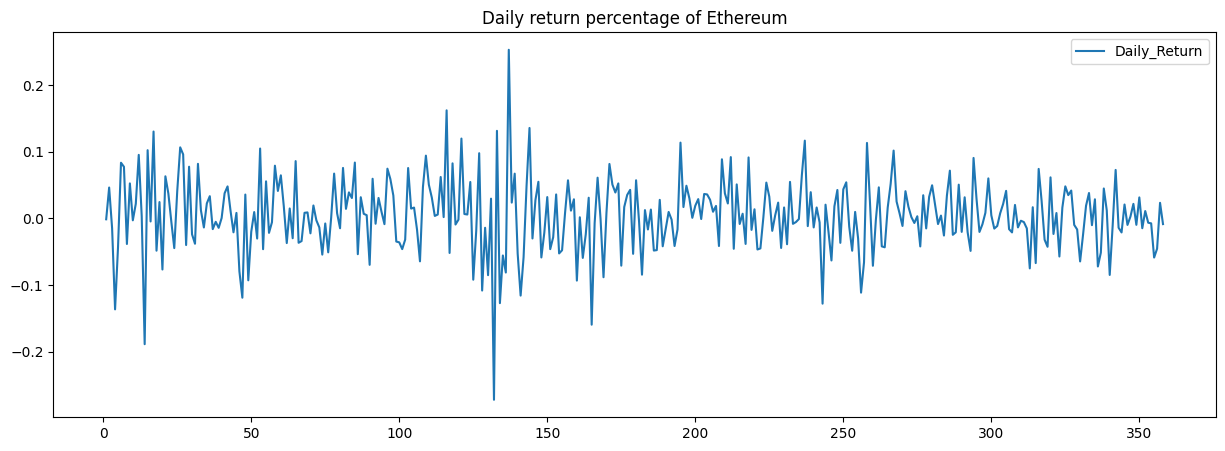

In [33]:
dataset_5_days['Daily_Return'] = dataset_5_days['Close'].pct_change()

# plot the daily return percentage
dataset_5_days.Daily_Return.plot(legend=True, figsize=(15,5))
plt.title('Daily return percentage of Ethereum')
plt.show()

<h2>Final Data Preparation</h2>
<h3>Change values for data training</h3>

(ZACZYNAMY OD TEGO MIEJSCA)

In [34]:
import numpy as np

# jeśli nie ma trade_sign → utwórz
if 'trade_sign' not in dataset_5_days.columns:
    # wariant 1: znak jednodniowej zmiany ceny Close
    ds = dataset_5_days.copy()
    close = ds['Close'].astype(float)
    trade_sign = np.sign(close.diff()).fillna(0.0)  # -1, 0, 1
    ds['trade_sign'] = trade_sign
    dataset_5_days = ds.dropna().copy()

print(dataset_5_days.columns.tolist())

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'MACD', '8SD', 'upper_band', 'lower_band', 'EMA', 'Daily_Return', 'trade_sign']


In [35]:
dataset_5_days_trade_sign = dataset_5_days[['Open', 'Close', 'High', 'Low', 'trade_sign']]

In [36]:
# normalize 5 days data
scaler = MinMaxScaler(feature_range=(-1,1)).fit(dataset_5_days_trade_sign)

data_5_days_trade_sign = scaler.transform(dataset_5_days_trade_sign)
print(data_5_days_trade_sign)

[[-0.87407895 -0.8838778  -0.88630991 -0.85774601 -1.        ]
 [-0.88430013 -0.97521087 -0.93224806 -1.         -1.        ]
 [-0.97621782 -1.         -0.99206799 -0.9536837  -1.        ]
 ...
 [ 0.46226968  0.37189456  0.43379344  0.41723742 -1.        ]
 [ 0.37453624  0.41717351  0.40163149  0.40796216  1.        ]
 [ 0.41766068  0.40060566  0.42277875  0.42993093 -1.        ]]


<h2>5 day long sequences</h2>

In [37]:
seq_len_5_days=6
sequences_5_days_trade_sign=[]
for index in range(len(data_5_days_trade_sign) - seq_len_5_days + 1): 
    sequences_5_days_trade_sign.append(data_5_days_trade_sign[index: index + seq_len_5_days])
sequences_5_days_trade_sign = np.array(sequences_5_days_trade_sign)

sequences_5_days_trade_sign

array([[[-0.87407895, -0.8838778 , -0.88630991, -0.85774601,
         -1.        ],
        [-0.88430013, -0.97521087, -0.93224806, -1.        ,
         -1.        ],
        [-0.97621782, -1.        , -0.99206799, -0.9536837 ,
         -1.        ],
        [-1.        , -0.95366789, -1.        , -0.96328799,
          1.        ],
        [-0.95407188, -0.90711884, -0.94154172, -0.91134563,
          1.        ],
        [-0.90540594, -0.93185893, -0.93816554, -0.91257929,
         -1.        ]],

       [[-0.88430013, -0.97521087, -0.93224806, -1.        ,
         -1.        ],
        [-0.97621782, -1.        , -0.99206799, -0.9536837 ,
         -1.        ],
        [-1.        , -0.95366789, -1.        , -0.96328799,
          1.        ],
        [-0.95407188, -0.90711884, -0.94154172, -0.91134563,
          1.        ],
        [-0.90540594, -0.93185893, -0.93816554, -0.91257929,
         -1.        ],
        [-0.93218749, -0.89911354, -0.91711476, -0.87730344,
          1. 

In [38]:
valid_set_size_percentage_trade_sign = 10 
test_set_size_percentage_trade_sign = 10 

valid_set_size_trade_sign = int(np.round(valid_set_size_percentage_trade_sign/100*sequences_5_days_trade_sign.shape[0]))  
test_set_size_trade_sign  = int(np.round(test_set_size_percentage_trade_sign/100*sequences_5_days_trade_sign.shape[0]))
train_set_size_trade_sign = sequences_5_days_trade_sign.shape[0] - (valid_set_size_trade_sign + test_set_size_trade_sign)

x_train_5_days_trade_sign = sequences_5_days_trade_sign[:train_set_size_trade_sign,:-1,:]
y_train_5_days_trade_sign = sequences_5_days_trade_sign[:train_set_size_trade_sign,-1,:]
    
x_valid_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign:train_set_size_trade_sign+valid_set_size_trade_sign,:-1,:]
y_valid_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign:train_set_size_trade_sign+valid_set_size_trade_sign,-1,:]
    
x_test_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign+valid_set_size_trade_sign:,:-1,:]
y_test_5_days_trade_sign = sequences_5_days_trade_sign[train_set_size_trade_sign+valid_set_size_trade_sign:,-1,:]

<h2>Building Neural Network and its components with Torch<h2>

In [39]:
from torch.utils.data import Dataset, DataLoader
import torch

class SequenceDataset(Dataset):
    """
    Gwarantuje spójne kształty:
      x: (N, T-1, F)
      y: (N, F)
    """
    def __init__(self, x_np, y_np):
        x = torch.as_tensor(x_np, dtype=torch.float32)
        y = torch.as_tensor(y_np, dtype=torch.float32)

        # Jeśli ktoś przez pomyłkę poda (N,1,F) albo (N,T,F) -> weź ostatni krok
        if y.ndim == 3:
            y = y[:, -1, :]

        assert x.ndim == 3, f"Expected x.ndim==3, got {x.ndim}"
        assert y.ndim == 2, f"Expected y.ndim==2, got {y.ndim}"
        assert x.shape[0] == y.shape[0], "x and y must have same N"
        assert x.shape[2] == y.shape[1], "feature dim must match (F)"

        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def make_loaders(
    x_train, y_train,
    x_valid, y_valid,
    x_test,  y_test,
    batch_size: int = 32,
    shuffle_train: bool = True,
    num_workers: int = 0,
    pin_memory: bool = False,
):
    train_ds = SequenceDataset(x_train, y_train)
    valid_ds = SequenceDataset(x_valid, y_valid)
    test_ds  = SequenceDataset(x_test,  y_test)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle_train,
                          num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    return train_dl, valid_dl, test_dl


# --- zbuduj dataloadery z już przygotowanych tablic ---
train_dataloader_5_days_trade_sign, \
valid_dataloader_5_days_trade_sign, \
test_dataloader_5_days_trade_sign = make_loaders(
    x_train_5_days_trade_sign, y_train_5_days_trade_sign,
    x_valid_5_days_trade_sign, y_valid_5_days_trade_sign,
    x_test_5_days_trade_sign,  y_test_5_days_trade_sign,
    batch_size=32, shuffle_train=True, num_workers=0, pin_memory=False
)

# Kontrola kształtów
xb, yb = next(iter(train_dataloader_5_days_trade_sign))
print("Batch shapes:", tuple(xb.shape), tuple(yb.shape))  # (B, T-1, F), (B, F)


Batch shapes: (32, 5, 5) (32, 5)


In [40]:
import torch.nn.functional as F  # opcjonalnie
from torch import nn

class NeuralNetwork(nn.Module):
    """
    Wejście:  x -> (B, T, F)
    Wyjście:  y -> (B, F)   (predykcja ostatniego kroku)
    """
    def __init__(self, num_feature: int, hidden_size: int = 64, num_layers: int = 1, dropout: float = 0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_feature,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, num_feature)

    def forward(self, x):
        # x: (B, T, F)
        output, (hidden, cell) = self.lstm(x)
        last_hidden = hidden[-1]         # (B, hidden_size)
        out = self.head(last_hidden)     # (B, F)
        return out


In [41]:
model = NeuralNetwork(5)

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [43]:
from torchinfo import summary
summary(model, input_size=(32, 5, 5))  # (batch, seq_len, features)

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [32, 5]                   --
├─LSTM: 1-1                              [32, 5, 64]               18,176
├─Linear: 1-2                            [32, 5]                   325
Total params: 18,501
Trainable params: 18,501
Non-trainable params: 0
Total mult-adds (M): 2.92
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.07
Estimated Total Size (MB): 0.16

In [44]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse = nn.MSELoss()

In [45]:
def train(dataloader, device="cpu"):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(x)           # (B, F)
        loss = mse(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    return running_loss / max(n_batches, 1)


In [46]:
def evaluate(dataloader, device="cpu"):
    model.eval()
    running_loss = 0.0
    n_batches = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)        # (B, F)
            loss = mse(pred, y)
            running_loss += loss.item()
            n_batches += 1

    return running_loss / max(n_batches, 1)


<h2>Training and Validation comparison plot function</h2>

In [47]:
def plot_loss(train_losses, valid_losses):
    plt.plot(train_losses, color='black', label='test loss')
    plt.plot(valid_losses, color='blue', label='validation loss')

    plt.title('Loss function comparison')
    plt.xlabel('time')
    plt.ylabel('loss values')
    plt.legend(loc='best')
    plt.show()

<h2>Network training loop</h2>

<h3>This code chunk contains code for best fit model</h3>

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

n_epochs = 1300
patience = 50
best_valid_loss = float('inf')
epochs_no_improve = 0

train_losses = []
valid_losses = []

for epoch_instance in range(1, n_epochs + 1):
    train_loss = train(train_dataloader_5_days_trade_sign, device=device)
    valid_loss = evaluate(valid_dataloader_5_days_trade_sign, device=device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    improved = valid_loss < best_valid_loss - 1e-8
    if improved:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'saved_weights.pt')  # zapisuj state_dict
    else:
        epochs_no_improve += 1

    if epoch_instance % 10 == 0 or improved:
        print(f"Epoch {epoch_instance:4d} | Train: {train_loss:.6f} | Val: {valid_loss:.6f}")

    if epochs_no_improve >= patience:
        print(f"Early stop (patience={patience}) @ epoch {epoch_instance}")
        break


Epoch    1 | Train: 0.358174 | Val: 0.641291
Epoch    2 | Train: 0.306957 | Val: 0.601422
Epoch    3 | Train: 0.254542 | Val: 0.515237
Epoch    4 | Train: 0.231425 | Val: 0.412393
Epoch    5 | Train: 0.215371 | Val: 0.330855
Epoch    6 | Train: 0.206156 | Val: 0.267074
Epoch    7 | Train: 0.203865 | Val: 0.234465
Epoch    8 | Train: 0.203538 | Val: 0.226905
Epoch   10 | Train: 0.201953 | Val: 0.222850
Epoch   11 | Train: 0.201603 | Val: 0.215440
Epoch   12 | Train: 0.201521 | Val: 0.210062
Epoch   13 | Train: 0.200544 | Val: 0.207339
Epoch   14 | Train: 0.200952 | Val: 0.205430
Epoch   15 | Train: 0.199976 | Val: 0.204166
Epoch   16 | Train: 0.200076 | Val: 0.202973
Epoch   17 | Train: 0.199756 | Val: 0.200459
Epoch   19 | Train: 0.198932 | Val: 0.196445
Epoch   20 | Train: 0.198810 | Val: 0.195575
Epoch   22 | Train: 0.198303 | Val: 0.193900
Epoch   23 | Train: 0.198482 | Val: 0.192530
Epoch   24 | Train: 0.197606 | Val: 0.191595
Epoch   25 | Train: 0.198721 | Val: 0.190046
Epoch   26

<h2> Visualization of results</h2>

In [49]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

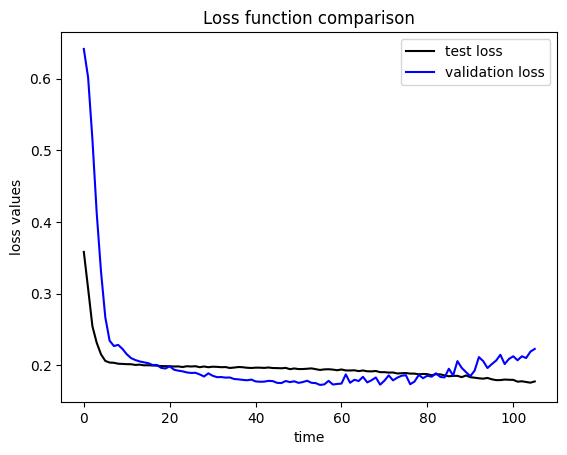

In [50]:
plot_loss(train_losses=train_losses, valid_losses=valid_losses)

<h2>Loading saved weights data and conducting Predictions</h2>
<h3>Continued part after skipping the hyperparameter tuning</h3>

In [51]:
# Ładujemy model i przełączamy w eval — UWAGA: ładujemy state_dict, a nie pełny obiekt!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_test = NeuralNetwork(5).to(device)
state = torch.load('saved_weights.pt', map_location=device)
model_test.load_state_dict(state)
model_test.eval()

@torch.no_grad()
def predict_full(model, loader, device="cpu"):
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pb = model(xb)           # (B, F)
        ys.append(yb.cpu())
        ps.append(pb.cpu())
    y = torch.cat(ys, dim=0).numpy()    # (N_test, F)
    p = torch.cat(ps, dim=0).numpy()    # (N_test, F)
    return y, p

y_test_np, y_pred_np = predict_full(model_test, test_dataloader_5_days_trade_sign, device=device)
print("Prediction shapes:", y_test_np.shape, y_pred_np.shape)


Prediction shapes: (35, 5) (35, 5)


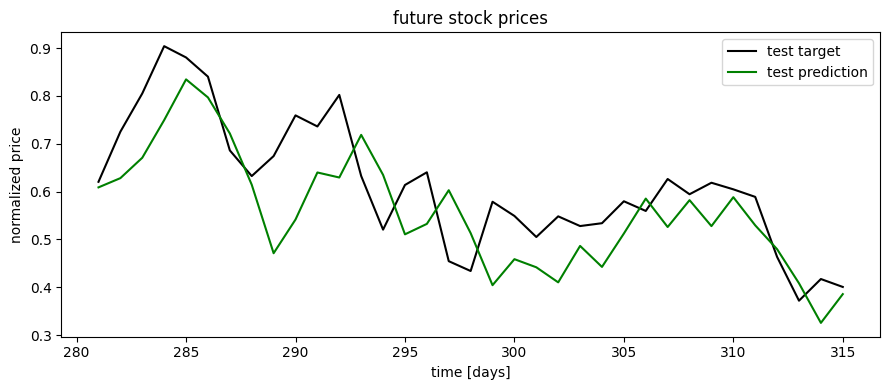

MAE  (Close): 0.08574316650629044
MAPE (Close): 0.14034639298915863


In [52]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

# Rysujemy np. 'Close' = idx=1 (Open=0, Close=1, High=2, Low=3, trade_sign=4)
idx = 1
n_train = len(y_train_5_days_trade_sign)
x_axis = np.arange(n_train, n_train + y_test_np.shape[0])

plt.figure(figsize=(9,4))
plt.plot(x_axis, y_test_np[:, idx],  color='black', label='test target')
plt.plot(x_axis, y_pred_np[:, idx],  color='green', label='test prediction')
plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print("MAE  (Close):", mean_absolute_error(y_test_np[:, idx], y_pred_np[:, idx]))
print("MAPE (Close):", mean_absolute_percentage_error(y_test_np[:, idx], y_pred_np[:, idx]))
